In [2]:
!pip install kaggle opendatasets transformers -q

In [3]:
import opendatasets as od
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import shutil
import pandas as pd
import warnings
import zipfile
warnings.filterwarnings('ignore')

In [21]:
# для ускорения обучения уменьшим размер картинок
IMG_SIZE = (128, 128)
BATCH_SIZE = 64
EPOCHS = 15

In [55]:
print("Загрузка датасетов: ")
try:
    dataset1_url = 'https://www.kaggle.com/datasets/vijaygiitk/multiclass-weather-dataset'
    od.download(dataset1_url)

    dataset2_url = 'https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset'
    od.download(dataset2_url)
except Exception as e:
    print(f"Ошибка загрузки: {e}")

# распаковка архивов
def extract_zip(zip_path, extract_to):
    if os.path.exists(zip_path):
        print("  Распаковываем:", os.path.basename(zip_path))
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        return True
    return False

zip_files = []
for root, dirs, files in os.walk('/content'):
    for file in files:
        if file.endswith('.zip'):
            zip_files.append(os.path.join(root, file))


for zip_file in zip_files:
    extract_dir = os.path.splitext(zip_file)[0] + '_extracted'
    if extract_zip(zip_file, extract_dir):
        print("  Распаковано в:", extract_dir)

Загрузка датасетов: 
Skipping, found downloaded files in "./multiclass-weather-dataset" (use force=True to force download)
Skipping, found downloaded files in "./multiclass-weather-dataset" (use force=True to force download)


In [56]:
print("Поиск изображений:")

def find_all_images(start_path):
    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
    images = []

    for root, dirs, files in os.walk(start_path):
        for file in files:
            if file.lower().endswith(image_extensions):
                images.append(os.path.join(root, file))

    return images

all_image_paths = []
search_paths = ['/content/multiclass-weather-dataset', '/content/multiclass-weather-dataset2']

for path in search_paths:
    if os.path.exists(path):
        images = find_all_images(path)
        all_image_paths.extend(images)
        print("  ", path, ": найдено", len(images), "изображений")

for root, dirs, files in os.walk('/content'):
    if '_extracted' in root:
        images = find_all_images(root)
        if images:
            all_image_paths.extend(images)
            print("  ", root, ": найдено", len(images), "изображений")

print("Всего найдено изображений: ", len(all_image_paths))


Поиск изображений:
   /content/multiclass-weather-dataset : найдено 1530 изображений
Всего найдено изображений:  1530


In [57]:
print("Анализ датасета: ")

def analyze_classes(image_paths):
    class_dict = {}

    for img_path in image_paths[:1000]:
        path_parts = img_path.lower().split('/')

        possible_classes = ['sunny', 'cloudy', 'rainy', 'foggy', 'shine', 'sunrise', 'rain', 'cloud']

        for part in path_parts:
            for cls in possible_classes:
                if cls in part:
                    if cls not in class_dict:
                        class_dict[cls] = []
                    class_dict[cls].append(img_path)
                    break

    return class_dict

class_dict = analyze_classes(all_image_paths)

print("\nНайденные классы: ")
for cls, paths in class_dict.items():
    print(cls, ": ", len(paths), "изображений")

Анализ датасета: 

Найденные классы: 
rainy :  300 изображений
rain :  306 изображений
sunrise :  707 изображений
foggy :  10 изображений
shine :  503 изображений
cloud :  4 изображений
cloudy :  140 изображений


In [58]:
print("Объединим в классы идентичные категории: ")

final_classes = ['sunny', 'cloudy', 'rainy', 'foggy']
print("Используем классы: ", final_classes)

class_mapping = {
    'shine': 'sunny',
    'sunrise': 'sunny',
    'rain': 'rainy',
    'cloud': 'cloudy',
    'cloudy': 'cloudy',
    'foggy': 'foggy',
    'fog': 'foggy'
}

combined_dir = '/content/weather_combined'
os.makedirs(combined_dir, exist_ok=True)

for class_name in final_classes:
    class_dir = os.path.join(combined_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

def distribute_images_to_classes(image_paths, target_dir, mapping, max_per_class=500):
    distributed = 0
    class_counts = {cls: 0 for cls in final_classes}

    for img_path in image_paths:
        path_lower = img_path.lower()
        assigned_class = None

        for src_class, target_class in mapping.items():
            if src_class in path_lower:
                assigned_class = target_class
                break

        if not assigned_class:
            filename = os.path.basename(path_lower)
            for src_class, target_class in mapping.items():
                if src_class in filename:
                    assigned_class = target_class
                    break

        if not assigned_class:
            idx = distributed % len(final_classes)
            assigned_class = final_classes[idx]

        if assigned_class in final_classes and class_counts[assigned_class] < max_per_class:
            dst_filename = f"{assigned_class}_{class_counts[assigned_class]:04d}{os.path.splitext(img_path)[1]}"
            dst_path = os.path.join(target_dir, assigned_class, dst_filename)

            try:
                shutil.copy2(img_path, dst_path)
                class_counts[assigned_class] += 1
                distributed += 1

                if distributed % 100 == 0:
                    print("Обработано: ", distributed, "изображений")
            except Exception as e:
                continue

    return class_counts

print("\nРаспределение изображений по классам: ")
class_counts = distribute_images_to_classes(all_image_paths, combined_dir, class_mapping, 400)

print("\nРезультат распределения: ")
total_images = 0
for class_name in final_classes:
    count = class_counts[class_name]
    total_images += count
    print(class_name, ": ", count, " изображений")

print("\nВсего распределено: ", total_images, "изображений")

min_per_class = 200
for class_name in final_classes:
    class_dir = os.path.join(combined_dir, class_name)
    current_images = [f for f in os.listdir(class_dir)
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if len(current_images) < min_per_class and len(current_images) > 0:
        to_add = min_per_class - len(current_images)
        existing = current_images.copy()

        for i in range(to_add):
            src_img = existing[i % len(existing)]
            src_path = os.path.join(class_dir, src_img)
            dst_path = os.path.join(class_dir, f"bal_{i:03d}_{src_img}")
            shutil.copy2(src_path, dst_path)

        final_count = len([f for f in os.listdir(class_dir)
                         if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        print(class_name, ": ", len(current_images), " - ", final_count)

Объединим в классы идентичные категории: 
Используем классы:  ['sunny', 'cloudy', 'rainy', 'foggy']

Распределение изображений по классам: 
Обработано:  100 изображений
Обработано:  200 изображений
Обработано:  300 изображений
Обработано:  400 изображений
Обработано:  500 изображений
Обработано:  600 изображений
Обработано:  700 изображений
Обработано:  800 изображений
Обработано:  900 изображений
Обработано:  1000 изображений
Обработано:  1100 изображений
Обработано:  1200 изображений
Обработано:  1300 изображений

Результат распределения: 
sunny :  400  изображений
cloudy :  304  изображений
rainy :  306  изображений
foggy :  310  изображений

Всего распределено:  1320 изображений


In [59]:
print("Делим датасет на train и validation: ")

final_dataset_dir = '/content/weather_final'
os.makedirs(os.path.join(final_dataset_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(final_dataset_dir, 'val'), exist_ok=True)

for class_name in final_classes:
    train_class_dir = os.path.join(final_dataset_dir, 'train', class_name)
    val_class_dir = os.path.join(final_dataset_dir, 'val', class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)

    class_dir = os.path.join(combined_dir, class_name)
    images = [f for f in os.listdir(class_dir)
             if f.lower().endswith(('.jpg', '.jpeg', '.png'))]


    train_imgs, val_imgs = train_test_split(
        images,
        test_size=0.2,
        random_state=42,
        shuffle=True
    )

    print("\nКопирование класса", class_name, ":")

    for img in train_imgs:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_class_dir, img)
        shutil.copy2(src, dst)

    for img in val_imgs:
        src = os.path.join(class_dir, img)
        dst = os.path.join(val_class_dir, img)
        shutil.copy2(src, dst)

    print("  Тренировочные: ", len(train_imgs))
    print("  Валидационные: ", len(val_imgs))

print("\nФинальный датасет создан: ", final_dataset_dir)

Делим датасет на train и validation: 

Копирование класса sunny :
  Тренировочные:  320
  Валидационные:  80

Копирование класса cloudy :
  Тренировочные:  243
  Валидационные:  61

Копирование класса rainy :
  Тренировочные:  244
  Валидационные:  62

Копирование класса foggy :
  Тренировочные:  248
  Валидационные:  62

Финальный датасет создан:  /content/weather_final


Подготовка к обучению: 
Проверка данных: 
  sunny: train=320, val=80
  cloudy: train=243, val=61
  rainy: train=244, val=62
  foggy: train=248, val=62
Found 1055 files belonging to 4 classes.
Found 265 files belonging to 4 classes.
Классы:  ['cloudy', 'foggy', 'rainy', 'sunny']
Тренировочные изображения:  1055
Валидационные изображения:  265
Примеры изображений (нормализованные): 


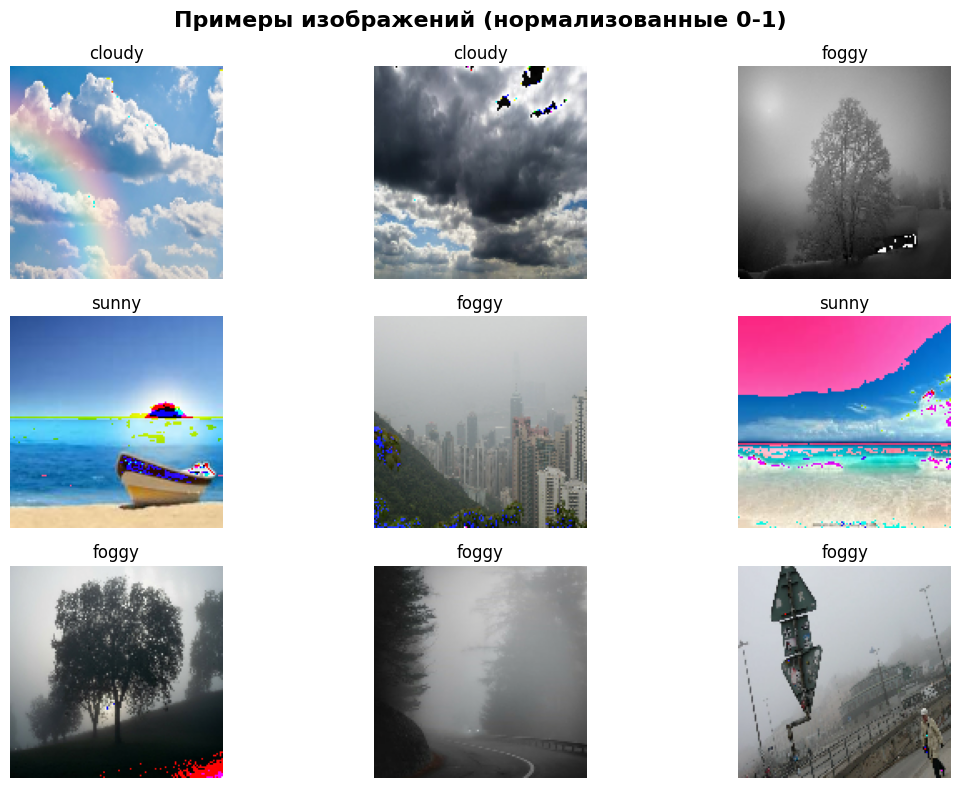

In [60]:
print("Подготовка к обучению: ")

train_dir = os.path.join(final_dataset_dir, 'train')
val_dir = os.path.join(final_dataset_dir, 'val')

print("Проверка данных: ")
for class_name in final_classes:
    train_count = len([f for f in os.listdir(os.path.join(train_dir, class_name))
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    val_count = len([f for f in os.listdir(os.path.join(val_dir, class_name))
                    if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    print(f"  {class_name}: train={train_count}, val={val_count}")

# Создаем датасеты без автоматической нормализации
train_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True,
    seed=42
)

val_ds_raw = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

class_names = train_ds_raw.class_names
print("Классы: ", class_names)

# Функция аугментации для тренировочных данных
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)  # На данных 0-255
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)  # На данных 0-255
    return image, label

def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds_raw.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds_raw.map(normalize_image, num_parallel_calls=tf.data.AUTOTUNE)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

train_count = sum(1 for _ in train_ds_raw.unbatch())
val_count = sum(1 for _ in val_ds_raw.unbatch())
print("Тренировочные изображения: ", train_count)
print("Валидационные изображения: ", val_count)

print("Примеры изображений (нормализованные): ")
plt.figure(figsize=(12, 8))
for images, labels in train_ds.take(1):
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i + 1)

        # Денормализуем обратно в 0-255 для отображения
        img_display = images[i].numpy()
        img_display = (img_display * 255).astype("uint8")

        plt.imshow(img_display)
        plt.title(f"{class_names[tf.argmax(labels[i])]}")
        plt.axis("off")

plt.suptitle("Примеры изображений (нормализованные 0-1)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [36]:
print("\nПроверка нормализации данных:")
for images, labels in train_ds.take(1):
    print(f"Диапазон значений после нормализации: {images.numpy().min():.3f} - {images.numpy().max():.3f}")
    print(f"Тип данных: {images.dtype}")
    print(f"Форма батча: {images.shape}")

print("\nПроверка raw данных (до нормализации):")
for images, labels in train_ds_raw.take(1):
    print(f"Диапазон значений до нормализации: {images.numpy().min()} - {images.numpy().max()}")
    print(f"Тип данных: {images.dtype}")


Проверка нормализации данных:
Диапазон значений после нормализации: -0.028 - 1.024
Тип данных: <dtype: 'float32'>
Форма батча: (64, 128, 128, 3)

Проверка raw данных (до нормализации):
Диапазон значений до нормализации: 0.0 - 255.0
Тип данных: <dtype: 'float32'>


In [37]:
for images, labels in train_ds.take(1):
    print(f"Диапазон значений: {images.numpy().min():.3f} - {images.numpy().max():.3f}")
    print(f"Все значения в [0, 1]: {np.all(images.numpy() >= 0) and np.all(images.numpy() <= 1)}")

    img = images[0].numpy()
    print(f"Min: {img.min():.3f}, Max: {img.max():.3f}, Mean: {img.mean():.3f}")


Проверка после исправления порядка операций:
Диапазон значений: 0.002 - 0.996
Все значения в [0, 1]: True
Min: 0.020, Max: 0.983, Mean: 0.534


In [38]:
# Создание моделей:

# 1. Простая CNN модель
def create_cnn_model(input_shape=(128, 128, 3), num_classes=4):
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),

        keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2),

        keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2),

        keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPooling2D(2),

        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dropout(0.3),

        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

# 2. MobileNetV2 с transfer learning
def create_mobilenet_model(input_shape=(128, 128, 3), num_classes=4):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        pooling='avg'
    )

    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

# 3. EfficientNetB0 с transfer learning
def create_efficientnet_model(input_shape=(128, 128, 3), num_classes=4):
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        pooling='avg'
    )

    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

In [39]:
# Создаем модели
print("Создание моделей: ")
cnn_model = create_cnn_model(num_classes=len(class_names))
mobilenet_model = create_mobilenet_model(num_classes=len(class_names))
efficientnet_model = create_efficientnet_model(num_classes=len(class_names))

models = {
    'CNN': cnn_model,
    'MobileNetV2': mobilenet_model,
    'EfficientNetB0': efficientnet_model
}

print("Информация о моделях: ")
for name, model in models.items():
    print(name, ":")
    model.summary()
    print()

Создание моделей: 
Информация о моделях: 
CNN :


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,172 (434.27 KB)

 Trainable params: 110,724 (432.52 KB)

 Non-trainable params: 448 (1.75 KB)


MobileNetV2 :


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


EfficientNetB0 :


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [40]:
print("Обучение моделей: ")

def compile_model(model, learning_rate=0.001):
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall')]
    )
    return model

def train_model(model, model_name, train_data, val_data, epochs=15):
    print("Обучение: ", model_name)

    if model_name == 'CNN':
        lr = 0.001
    else:
        lr = 0.0005

    model = compile_model(model, learning_rate=lr)

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            f'best_{model_name.lower()}.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    return history

histories = {}
for name, model in models.items():
    history = train_model(model, name, train_ds, val_ds, epochs=EPOCHS)
    histories[name] = history

Обучение моделей: 
Обучение:  CNN
Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4688 - loss: 1.2630 - precision: 0.5563 - recall: 0.3255
Epoch 1: val_accuracy improved from -inf to 0.36226, saving model to best_cnn.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.4736 - loss: 1.2539 - precision: 0.5611 - recall: 0.3315 - val_accuracy: 0.3623 - val_loss: 1.3522 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6755 - loss: 0.8284 - precision: 0.7459 - recall: 0.5759
Epoch 2: val_accuracy did not improve from 0.36226
17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6764 - loss: 0.8258 - precision: 0.7462 - recall: 0.5775 - val_accuracy: 0.3509 - val_loss: 1.3264 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7232 - loss: 0.7263 - precision: 0.7606 - recall: 0.6660
Epoch 3: val_accuracy did not improve from 0.36226
17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7231 - loss: 0.7260 - precision: 0.7607 - recall: 0.6665 - val_accuracy: 0.2453 - val_loss: 1.3898 - val_precision: 0.0000e+00 - val_recall: 0.0000

17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 805ms/step - accuracy: 0.3833 - loss: 1.7229 - precision: 0.4067 - recall: 0.2911 - val_accuracy: 0.8302 - val_loss: 0.5413 - val_precision: 0.8717 - val_recall: 0.7434 - learning_rate: 5.0000e-04
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 557ms/step - accuracy: 0.7309 - loss: 0.6610 - precision: 0.7793 - recall: 0.6692
Epoch 2: val_accuracy did not improve from 0.83019
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 710ms/step - accuracy: 0.7316 - loss: 0.6591 - precision: 0.7798 - recall: 0.6700 - val_accuracy: 0.8302 - val_loss: 0.4076 - val_precision: 0.8623 - val_recall: 0.8038 - learning_rate: 5.0000e-04
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.8157 - loss: 0.5135 - precision: 0.8412 - recall: 0.7863
Epoch 3: val_accuracy improved from 0.83019 to 0.86792, saving model to best_mobilenetv2.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 696ms/step - accuracy: 0.8164 - loss: 0.5119 - precision: 0.8419 - recall: 0.7871 - val_accuracy: 0.8679 - val_loss: 0.3456 - val_precision: 0.8706 - val_recall: 0.8377 - learning_rate: 5.0000e-04
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.8490 - loss: 0.4025 - precision: 0.8612 - recall: 0.8189
Epoch 4: val_accuracy improved from 0.86792 to 0.87925, saving model to best_mobilenetv2.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 720ms/step - accuracy: 0.8490 - loss: 0.4021 - precision: 0.8614 - recall: 0.8191 - val_accuracy: 0.8792 - val_loss: 0.3109 - val_precision: 0.8911 - val_recall: 0.8642 - learning_rate: 5.0000e-04
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.8651 - loss: 0.3519 - precision: 0.8852 - recall: 0.8492
Epoch 5: val_accuracy improved from 0.87925 to 0.89434, saving model to best_mobilenetv2.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 690ms/step - accuracy: 0.8652 - loss: 0.3522 - precision: 0.8850 - recall: 0.8491 - val_accuracy: 0.8943 - val_loss: 0.2916 - val_precision: 0.8962 - val_recall: 0.8792 - learning_rate: 5.0000e-04
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.8828 - loss: 0.3126 - precision: 0.8996 - recall: 0.8650
Epoch 6: val_accuracy improved from 0.89434 to 0.90189, saving model to best_mobilenetv2.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 853ms/step - accuracy: 0.8826 - loss: 0.3136 - precision: 0.8991 - recall: 0.8647 - val_accuracy: 0.9019 - val_loss: 0.2730 - val_precision: 0.9062 - val_recall: 0.8755 - learning_rate: 5.0000e-04
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.8942 - loss: 0.2866 - precision: 0.9073 - recall: 0.8750
Epoch 7: val_accuracy did not improve from 0.90189
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 698ms/step - accuracy: 0.8940 - loss: 0.2868 - precision: 0.9068 - recall: 0.8750 - val_accuracy: 0.8981 - val_loss: 0.2674 - val_precision: 0.9035 - val_recall: 0.8830 - learning_rate: 5.0000e-04
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 539ms/step - accuracy: 0.9097 - loss: 0.2421 - precision: 0.9202 - recall: 0.8925
Epoch 8: val_accuracy improved from 0.90189 to 0.90566, saving model to best_mobilenetv2.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 709ms/step - accuracy: 0.9093 - loss: 0.2430 - precision: 0.9197 - recall: 0.8922 - val_accuracy: 0.9057 - val_loss: 0.2631 - val_precision: 0.9151 - val_recall: 0.8943 - learning_rate: 5.0000e-04
Epoch 9/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.9105 - loss: 0.2356 - precision: 0.9164 - recall: 0.8966
Epoch 9: val_accuracy improved from 0.90566 to 0.91321, saving model to best_mobilenetv2.h5


17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 992ms/step - accuracy: 0.9104 - loss: 0.2358 - precision: 0.9165 - recall: 0.8966 - val_accuracy: 0.9132 - val_loss: 0.2483 - val_precision: 0.9198 - val_recall: 0.9094 - learning_rate: 5.0000e-04
Epoch 10/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.9137 - loss: 0.2255 - precision: 0.9206 - recall: 0.9119
Epoch 10: val_accuracy did not improve from 0.91321
17/17 ━━━━━━━━━━━━━━━━━━━━ 14s 800ms/step - accuracy: 0.9138 - loss: 0.2260 - precision: 0.9206 - recall: 0.9120 - val_accuracy: 0.8906 - val_loss: 0.2709 - val_precision: 0.9004 - val_recall: 0.8868 - learning_rate: 5.0000e-04
Epoch 11/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.9121 - loss: 0.2139 - precision: 0.9179 - recall: 0.9095
Epoch 11: val_accuracy did not improve from 0.91321
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 683ms/step - accuracy: 0.9120 - loss: 0.2145 - precision: 0.9178 - recall: 0.9093 - val_accuracy: 0.8981 - val_loss: 0.2481 - val_precision: 0.8973 - val_recall:

17/17 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.2372 - loss: 1.4430 - precision: 0.1609 - recall: 0.0070 - val_accuracy: 0.3019 - val_loss: 1.3888 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.2563 - loss: 1.4378 - precision: 0.2339 - recall: 0.0031
Epoch 2: val_accuracy did not improve from 0.30189
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.2568 - loss: 1.4365 - precision: 0.2394 - recall: 0.0031 - val_accuracy: 0.3019 - val_loss: 1.3794 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.2461 - loss: 1.4254 - precision: 0.1706 - recall: 9.5031e-04
Epoch 3: val_accuracy did not improve from 0.30189
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.2478 - loss: 1.4241 - precision: 0.1833 - recall: 0.0010 - val_accuracy: 0.3019 - val_loss: 1.3837 - val_precision: 0.0000e+00 - 

Оценка моделей по метрикам: 
Оценка  CNN : 
  Accuracy:  0.36226415634155273
  Loss:  1.3522467613220215

Classification Report: 
              precision    recall  f1-score   support

      cloudy       0.00      0.00      0.00        61
       foggy       0.27      0.65      0.38        62
       rainy       0.50      0.02      0.03        62
       sunny       0.47      0.69      0.56        80

    accuracy                           0.36       265
   macro avg       0.31      0.34      0.24       265
weighted avg       0.32      0.36      0.27       265



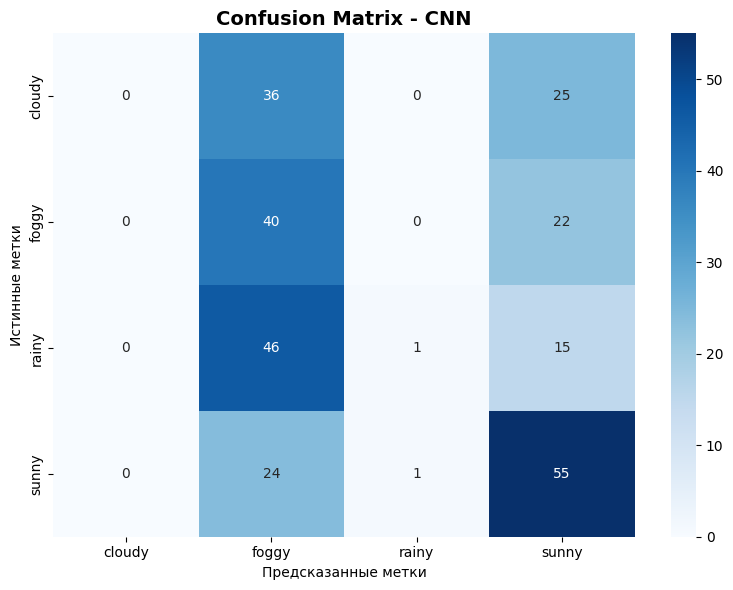

Оценка  MobileNetV2 : 
  Accuracy:  0.9132075309753418
  Loss:  0.2483224868774414
  Precision:  0.919847309589386
  Recall:  0.9094339609146118

Classification Report: 
              precision    recall  f1-score   support

      cloudy       0.88      0.85      0.87        61
       foggy       0.88      0.98      0.93        62
       rainy       0.95      0.94      0.94        62
       sunny       0.93      0.89      0.91        80

    accuracy                           0.91       265
   macro avg       0.91      0.91      0.91       265
weighted avg       0.91      0.91      0.91       265



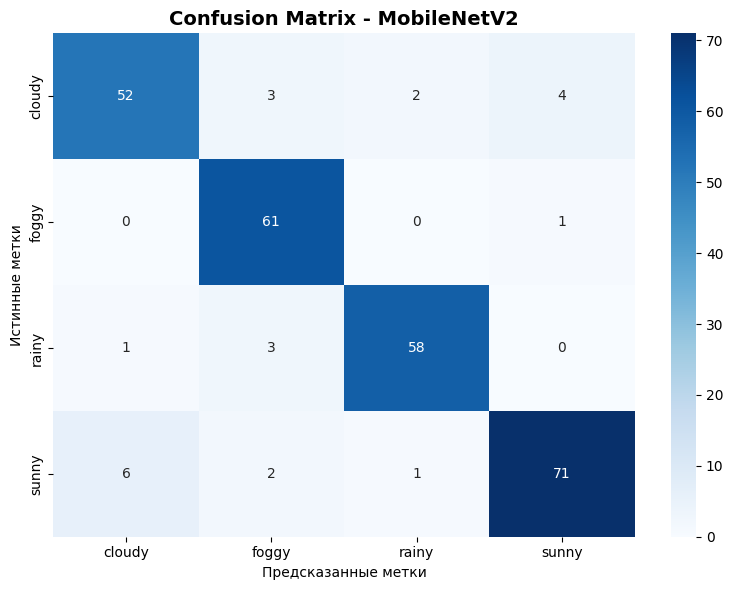

Оценка  EfficientNetB0 : 
  Accuracy:  0.30188679695129395
  Loss:  1.3887876272201538

Classification Report: 
              precision    recall  f1-score   support

      cloudy       0.00      0.00      0.00        61
       foggy       0.00      0.00      0.00        62
       rainy       0.00      0.00      0.00        62
       sunny       0.30      1.00      0.46        80

    accuracy                           0.30       265
   macro avg       0.08      0.25      0.12       265
weighted avg       0.09      0.30      0.14       265



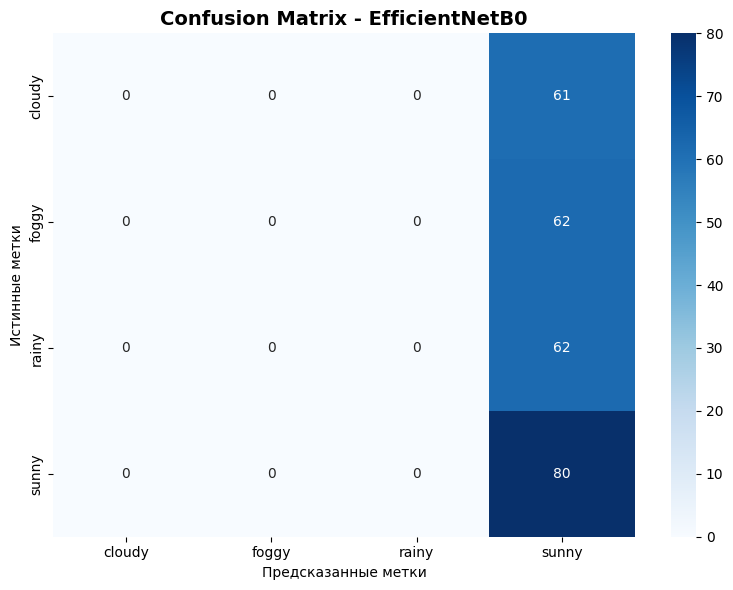

In [41]:
print("Оценка моделей по метрикам: ")

results = {}

def evaluate_model(model, val_data, model_name):
    print("Оценка ", model_name, ": ")

    evaluation = model.evaluate(val_data, verbose=0)

    if len(evaluation) == 4:  # loss, accuracy, precision, recalluation
        loss, accuracy, precision, recall = evaluation
    else:
        loss, accuracy = evaluation
        precision = recall = 0.0

    results[model_name] = {
        'accuracy': accuracy,
        'loss': loss,
        'precision': precision,
        'recall': recall
    }

    print("  Accuracy: ", accuracy)
    print("  Loss: ", loss)
    if precision > 0:
        print("  Precision: ", precision)
        print("  Recall: ", recall)

    # Составим матрицы неточностей
    y_true = []
    y_pred = []

    for images, labels in val_data:
        preds = model.predict(images, verbose=0)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    print("\nClassification Report: ")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Предсказанные метки')
    plt.ylabel('Истинные метки')
    plt.tight_layout()
    plt.show()

    return results[model_name]

for name, model in models.items():
    evaluate_model(model, val_ds, name)

Сравнение результатов. 
Сравнительная таблица метрик: 
                accuracy      loss  precision    recall
CNN             0.362264  1.352247   0.000000  0.000000
MobileNetV2     0.913208  0.248322   0.919847  0.909434
EfficientNetB0  0.301887  1.388788   0.000000  0.000000


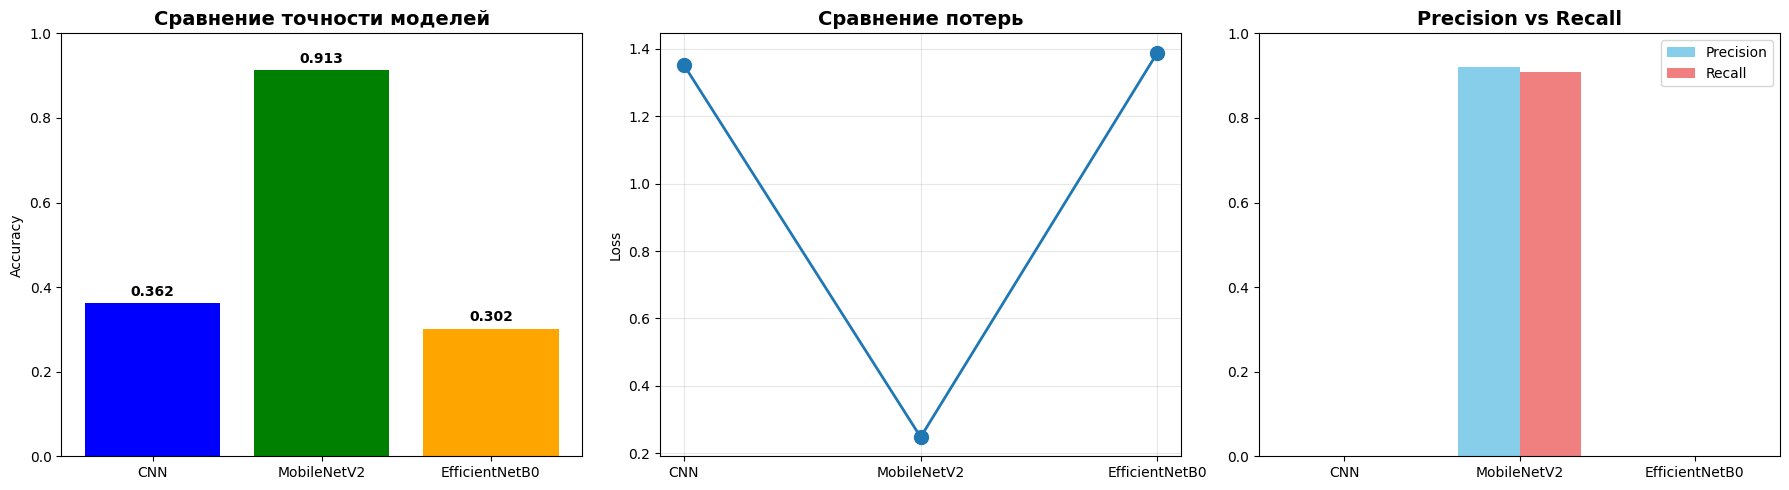


Лучшая модель:  MobileNetV2
Точность:  0.9132075309753418
Сохраняем финальную модель для использования в боте: 
Финальная модель сохранена как 'best_weather_classifier_final.h5'


In [42]:
print("Сравнение результатов. ")
results_df = pd.DataFrame(results).T
print("Сравнительная таблица метрик: ")
print(results_df)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# График точности
models_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in models_names]

bars = axes[0].bar(models_names, accuracies, color=['blue', 'green', 'orange'])
axes[0].set_title('Сравнение точности моделей', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0, 1])
for bar, acc in zip(bars, accuracies):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

losses = [results[name]['loss'] for name in models_names]
axes[1].plot(models_names, losses, 'o-', linewidth=2, markersize=10)
axes[1].set_title('Сравнение потерь', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Loss')
axes[1].grid(True, alpha=0.3)

# Precision-Recell
if 'precision' in results[models_names[0]]:
    precisions = [results[name]['precision'] for name in models_names]
    recalls = [results[name]['recall'] for name in models_names]

    width = 0.35
    x = np.arange(len(models_names))
    axes[2].bar(x - width/2, precisions, width, label='Precision', color='skyblue')
    axes[2].bar(x + width/2, recalls, width, label='Recall', color='lightcoral')
    axes[2].set_title('Precision vs Recall', fontsize=14, fontweight='bold')
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(models_names)
    axes[2].legend()
    axes[2].set_ylim([0, 1])

plt.tight_layout()
plt.show()

best_model_name = max(results, key=lambda x: results[x]['accuracy'])
best_accuracy = results[best_model_name]['accuracy']


print("\nЛучшая модель: ", best_model_name)
print("Точность: ", best_accuracy)

if best_model_name == 'CNN':
    best_model = cnn_model
elif best_model_name == 'MobileNetV2':
    best_model = mobilenet_model
else:
    best_model = efficientnet_model

best_model.load_weights(f'best_{best_model_name.lower()}.h5')

print("Сохраняем финальную модель для использования в боте: ")
best_model.save('best_weather_classifier_final.h5')
print("Финальная модель сохранена как 'best_weather_classifier_final.h5'")

Тестирование модели: 
Тестирование на случайных изображениях из валидационного набора:


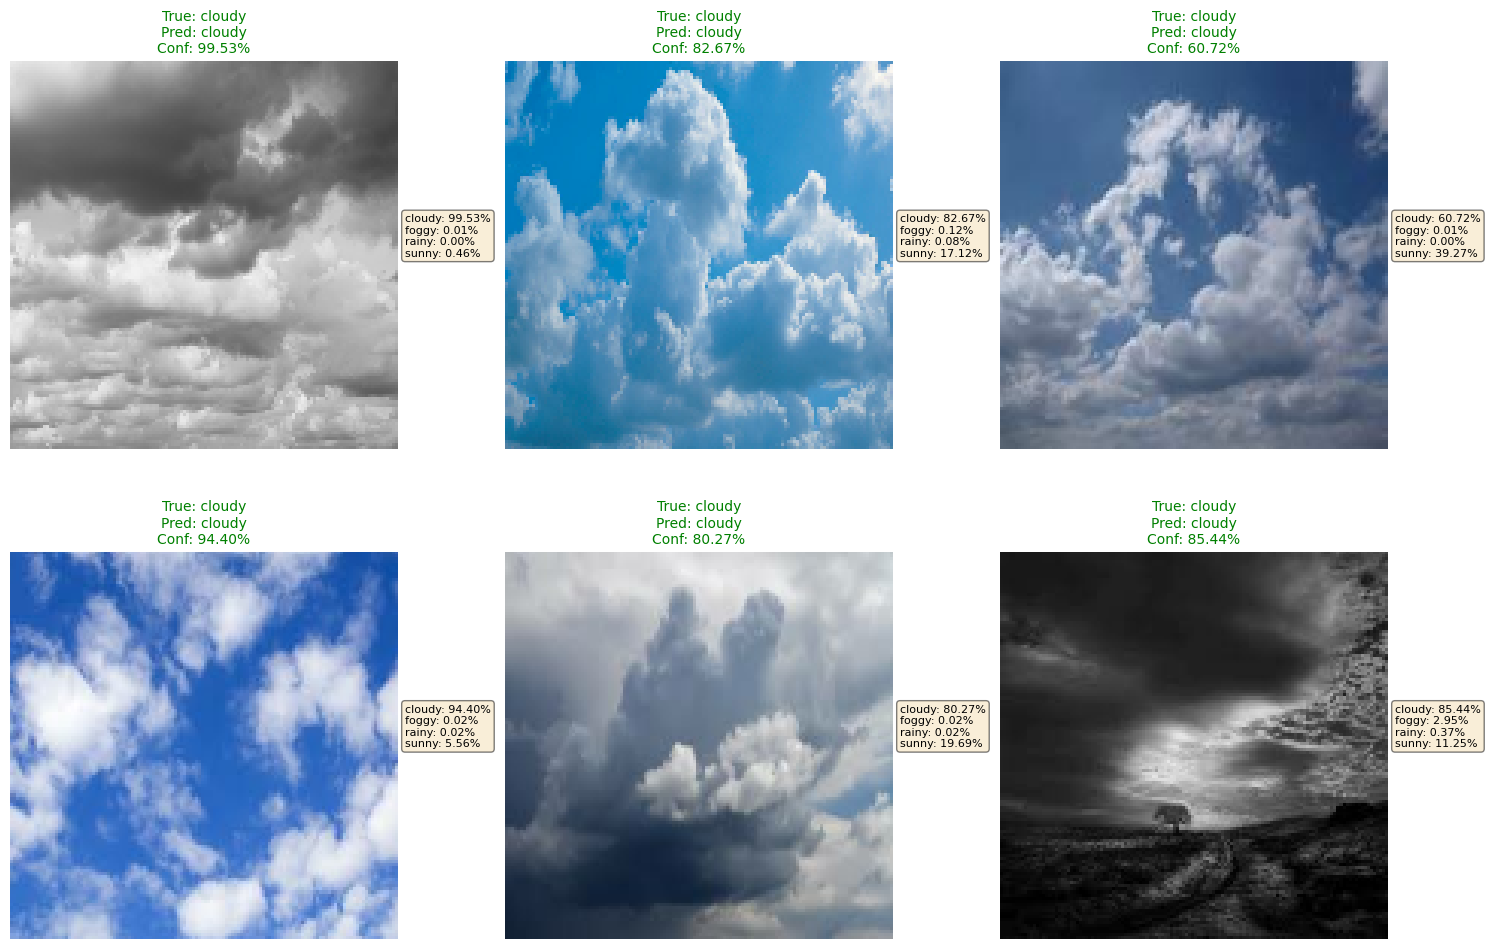



Тестирование на реальных файлах из валидационной папки:


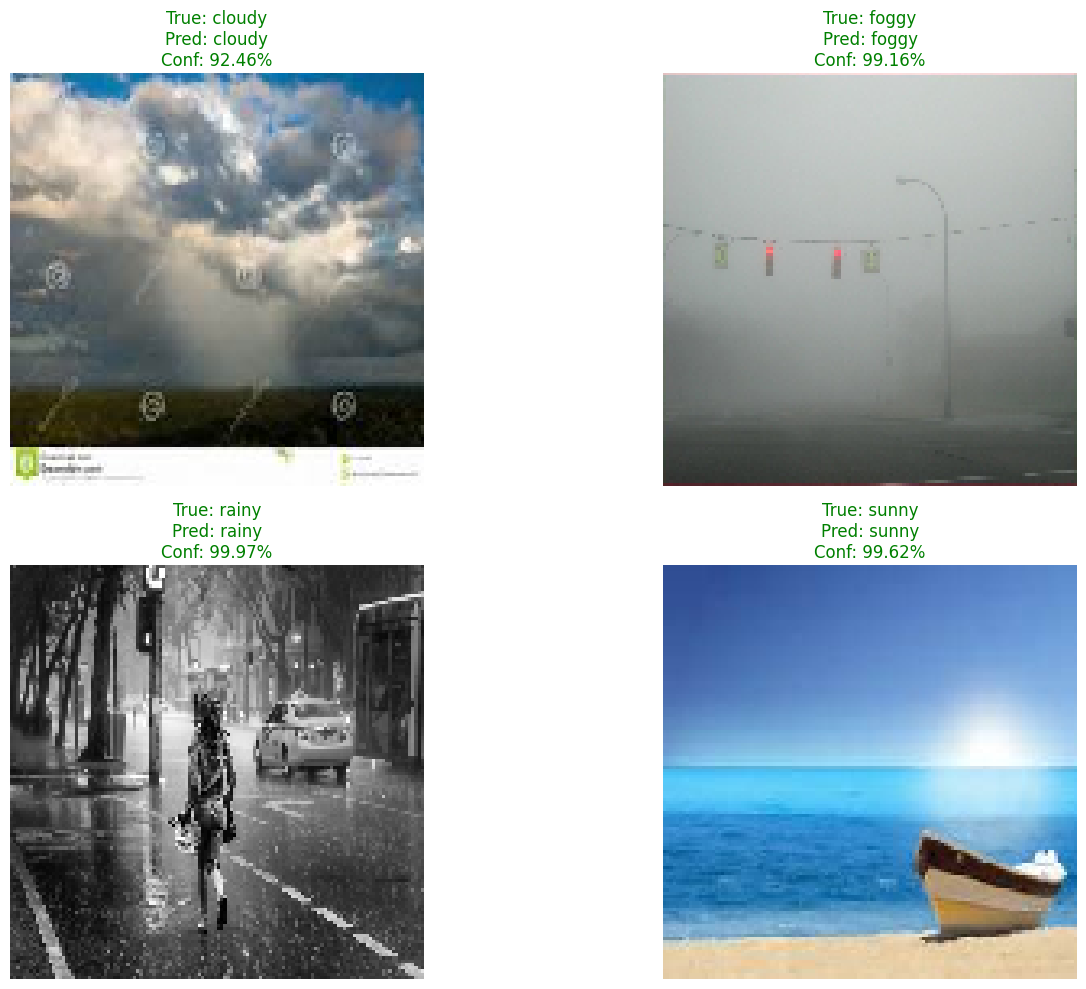

In [49]:
print("Тестирование модели: ")

def predict_image(model, image_array):

    img_array = tf.expand_dims(image_array, 0)

    predictions = model.predict(img_array, verbose=0)[0]
    predicted_idx = np.argmax(predictions)
    predicted_class = class_names[predicted_idx]
    confidence = predictions[predicted_idx]

    return predicted_class, confidence, predictions

print("Тестирование на случайных изображениях из валидационного набора:")
num_test = 6
plt.figure(figsize=(15, 10))

for i, (images, labels) in enumerate(val_ds.take(1)):
    for j in range(min(num_test, len(images))):
        img = images[j].numpy()
        true_label_idx = tf.argmax(labels[j]).numpy()
        true_label = class_names[true_label_idx]

        predicted_class, confidence, all_probs = predict_image(best_model, img)

        plt.subplot(2, 3, j+1)
        img_display = (img * 255).astype(np.uint8)
        plt.imshow(img_display)
        plt.axis('off')

        color = 'green' if predicted_class == true_label else 'red'

        title = f'True: {true_label}\nPred: {predicted_class}\nConf: {confidence:.2%}'
        plt.title(title, color=color, fontsize=10)

        text = '\n'.join([f'{cls}: {prob:.2%}'
                         for cls, prob in zip(class_names, all_probs)])
        plt.text(130, 64, text, fontsize=8,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\nТестирование на реальных файлах из валидационной папки:")
import random

test_samples = []
for class_name in class_names:
    class_path = os.path.join(val_dir, class_name)
    images = [f for f in os.listdir(class_path)
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if images:
        test_samples.append((class_name, os.path.join(class_path, random.choice(images))))

plt.figure(figsize=(15, 10))
for i, (true_class, img_path) in enumerate(test_samples):
    img = keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0

    predicted_class, confidence, all_probs = predict_image(best_model, img_array)

    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.axis('off')

    color = 'green' if predicted_class == true_class else 'red'
    title = f'True: {true_class}\nPred: {predicted_class}\nConf: {confidence:.2%}'
    plt.title(title, color=color, fontsize=12)

plt.tight_layout()
plt.show()

In [44]:
print("Отчет о проекте: ")

print("- Классы: ", class_names)
print("- Размер изображений: ", IMG_SIZE)
print("- Тренировочные данные: ", train_count, "изображений")
print("- Валидационные данные: ", val_count, "изображений")
print("- Batch size: ", BATCH_SIZE)
print("- Эпох обучения: ", EPOCHS)

print("Результаты моделей: ")
for name, metrics in results.items():
    accuracy = metrics['accuracy']
    if accuracy >= 0.8:
      status = "Цель достигнута."
    else:
      status = "Цель недостигнута."
    print(name, ": ", accuracy, " - ", status)

print("\nЛучшая модель: ", best_model_name)
print("Точность: ", best_accuracy)

Отчет о проекте: 
- Классы:  ['cloudy', 'foggy', 'rainy', 'sunny']
- Размер изображений:  (128, 128)
- Тренировочные данные:  1055 изображений
- Валидационные данные:  265 изображений
- Batch size:  64
- Эпох обучения:  15
Результаты моделей: 
CNN :  0.36226415634155273  -  Цель недостигнута.
MobileNetV2 :  0.9132075309753418  -  Цель достигнута.
EfficientNetB0 :  0.30188679695129395  -  Цель недостигнута.

Лучшая модель:  MobileNetV2
Точность:  0.9132075309753418


In [45]:
print("Сохранение результатов: ")
results_df.to_csv('weather_classification_results.csv')
print("Результаты сохранены в 'weather_classification_results.csv'")

Сохранение результатов: 
Результаты сохранены в 'weather_classification_results.csv'


In [46]:
import pickle

In [47]:
print("Сохранение истории обучения: ")
with open('training_history.pkl', 'wb') as f:
    pickle.dump(histories, f)
print("История обучения сохранена в 'training_history.pkl'")

class_info = {
    'class_names': class_names,
    'img_size': IMG_SIZE,
    'best_model': best_model_name,
    'best_accuracy': float(best_accuracy),
    'all_results': results
}

with open('class_info.pkl', 'wb') as f:
    pickle.dump(class_info, f)
print("Информация о классах сохранена в 'class_info.pkl'")

Сохранение истории обучения: 
История обучения сохранена в 'training_history.pkl'
Информация о классах сохранена в 'class_info.pkl'
